In this notebook we explore the questions "Why do certain kernels behave the way they do (and why do PCA / no-PCA change that)?"

To answer this question in a structured way we devide the analysis in 2 parts - first for the global kernels and second for the local kernels.

Linear & Polynomial kernels:

- Look at: global structure, block patterns, effect of PCA on structure, eigenvalue spectrum (rank, decay); ingore locality (they dont have it)
- Questions to answer: Does PCA make the Gram matrix more structured? Does polynomial introduce higher-rank structure? Why does linear perform poorly (or not)?

RBF & Laplacian kernels:
- look at: locality (diagonal dominance), smoothness vs sharp decay, effect of γ, PCA’s impact on neighborhood structure
- Questions to answer: How tight are neighborhoods? Does Laplacian decay more sharply than RBF? Does PCA improve or hurt locality? Why does one outperform the other?

To diagnose kernels we will use the following tools:
-  Gram (kernel) matrix: The Gram matrix stores how similar every data point is to every other data point under a given kernel, so it fully describes how the kernel “sees” the dataset.
- Gram matrix visualization (heatmap): Plotting the Gram matrix lets us visually inspect whether the kernel encodes global similarity, local neighborhoods, or structured blocks, which helps explain why certain kernels perform better.
- Eigenvalue spectrum of the Gram matrix: the eigenvalues show how complex or expressive the kernel is, with faster decay indicating a simpler, lower-rank structure and slower decay indicating higher flexibility (and potentially higher variance).
- Eigenvalue spectrum plot: Plotting the eigenvalues helps us compare kernels and representations by showing how much effective dimensionality or noise each kernel introduces.
- Locality (diagonal dominance) score: The locality score measures how much a kernel focuses on nearby points by comparing diagonal values to off-diagonal values, which is especially important for understanding RBF and Laplacian kernels.
-Effect of PCA: PCA can change kernel behavior by removing noise and redundant directions, often leading to cleaner Gram matrices and more stable eigenvalue spectra, though its benefit depends on the kernel type.

In [13]:

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from src.config import SEED
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parents[0]
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"


In [2]:
krr_results = pd.read_csv(RESULTS_DIR / "tables" / "krr_results.csv")
lr_results  = pd.read_csv(RESULTS_DIR / "tables" / "lr_results.csv")


In [4]:
X_scaled = np.load(DATA_DIR / "X_scaled.npy")
X_pca = np.load(DATA_DIR / "X_pca.npy")


In [9]:
diag_subsample_size = 800  # chosen to balance cost and structure

rng = np.random.default_rng(SEED)
diag_idx = rng.choice(len(X_scaled), size=diag_subsample_size, replace=False)

X_scaled_diag = X_scaled[diag_idx]
X_pca_diag = X_pca[diag_idx]

print("Diagnostic subsample shapes:")
print("X_scaled_diag:", X_scaled_diag.shape)
print("X_pca_diag   :", X_pca_diag.shape)

Diagnostic subsample shapes:
X_scaled_diag: (800, 81)
X_pca_diag   : (800, 17)


# Section 1. Helper functions
get_best_params, compute_gram, plot_gram, eigen_spectrum, plot_eigs, locality_summary

In [18]:

def get_best_params(results_df, model, kernel, representation):
    row = results_df[
        (results_df["model"] == model) &
        (results_df["kernel"] == kernel) &
        (results_df["representation"] == representation)
    ]

    if row.empty:
        raise ValueError(
            f"No results for model={model}, kernel={kernel}, "
            f"representation={representation}"
        )

    row = row.iloc[0]

    params = {}
    for key in ["best_gamma", "best_degree", "best_coef0", "best_lambda"]:
        if key in row and row[key] != "N/A" and not pd.isna(row[key]):
            params[key.replace("best_", "")] = float(row[key])

    return params


def compute_gram(kernel_obj, X):
    return kernel_obj(X, X)


def plot_gram_matrix(K, title):
    # plot a Gram matrix as a heatmap.
    plt.figure(figsize=(5, 5))
    plt.imshow(K, cmap="viridis", aspect="auto")
    plt.colorbar(label="Kernel value")
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Sample index")
    plt.tight_layout()
    plt.show()


def eigen_spectrum(K):
    eigvals = np.linalg.eigvalsh(K)
    return np.sort(eigvals)[::-1]


def plot_eigen_spectrum(eigvals, title, log_scale=True):
    plt.figure(figsize=(5, 4))
    if log_scale:
        plt.semilogy(eigvals)
    else:
        plt.plot(eigvals)

    plt.xlabel("Eigenvalue index")
    plt.ylabel("Eigenvalue magnitude")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def locality_score(K):
    diag = np.diag(K)
    row_sums = np.sum(K, axis=1)
    return float(np.mean(diag / (row_sums + 1e-12)))

# Section 2. Diagnostics: Global kernels (Linear, Polynomial)
We use the best hyperparameters obtained from Kernel Ridge Regression results, as Gram matrix structure is most directly tied to KRR. (important to be mentioned and reasoned about in report)


Linear kernel — SCALED


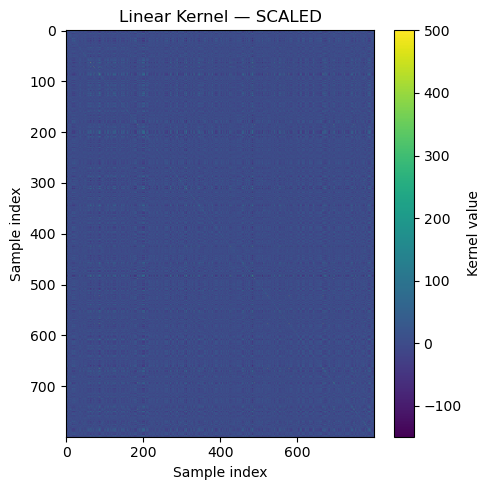

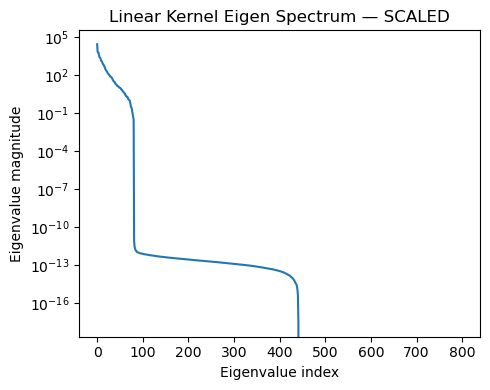

Effective rank (λ > 1e-6): 81

Linear kernel — PCA


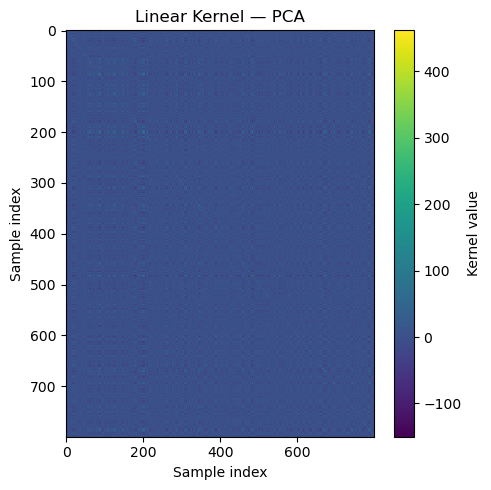

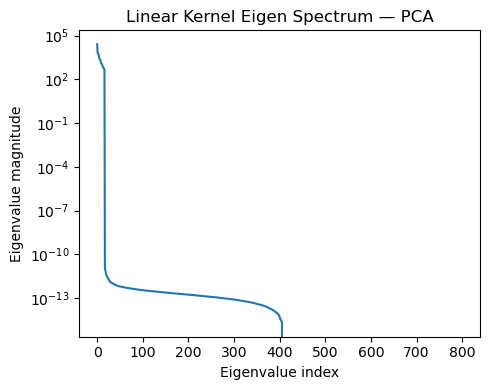

Effective rank (λ > 1e-6): 17


In [19]:

from src.kernels.linear import LinearKernel

MODEL_FOR_DIAGNOSTICS = "kernel_ridge_regression"
KERNEL_NAME = "linear"

for representation, X_diag in [
    ("scaled", X_scaled_diag),
    ("pca", X_pca_diag),
]:
    print(f"\nLinear kernel — {representation.upper()}")
    linear_kernel = LinearKernel()

    K = compute_gram(linear_kernel, X_diag)

    plot_gram_matrix(
        K,
        title=f"Linear Kernel — {representation.upper()}"
    )

    # Eigenvalue spectrum
    eigvals = eigen_spectrum(K)
    plot_eigen_spectrum(
        eigvals,
        title=f"Linear Kernel Eigen Spectrum — {representation.upper()}"
    )

    # Simple diagnostics
    effective_rank = np.sum(eigvals > 1e-6)
    print(f"Effective rank (λ > 1e-6): {effective_rank}")

# Section 3. Diagnostics: Local kernels (RBF, Laplacian)

# Section 4. Summary table